In [1]:
# imports
import os
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
import sklearn
from sklearn import decomposition, cluster
from sklearn.linear_model import LinearRegression as linreg


import TwoPUtils



%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
with open("/home/mplitt/2P_scratch/all_session_dict.pkl","rb") as f:
    all_sessions = pickle.load(f)

In [25]:
mouse = "GRABDA4"
ind = 1

f = all_sessions[mouse][ind]
f['mouse']=mouse


scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
try:
    source_folder  = os.path.join('/media/mplitt','Backup Plus')
    source_stem = os.path.join(source_folder,f['mouse'],f['date'],f['scene'],scan_str)
    info = TwoPUtils.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')
except:
    source_folder  = os.path.join('/media/mplitt','Backup Plus1','2P_Data')
    source_stem = os.path.join(source_folder,f['mouse'],f['date'],f['scene'],scan_str)
    info = TwoPUtils.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')

f.update({'scan_file': source_stem + '.sbx',
          'scanheader_file': source_stem + '.mat',
          'vr_filename': os.path.join("/home/mplitt/VR_scratch",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
          'scan_number': f['scan'],
          'prompt_for_keys': False,
          'VR_only': False,
          'scanner': "NLW",
          'zstack_path': os.path.join("/mnt/BigDisk/2P_scratch",f['mouse'],"ZStack","ZStack_000_001"),
         })
if f['mouse'] == 'GRABDA6':
    f['s2p_path']=os.path.join("/home/mplitt/2P_scratch",f['mouse'],f['date'],f['scene'],scan_str,'suite2p')
else:
    f['s2p_path']=os.path.join("/mnt/BigDisk/2P_scratch",f['mouse'],f['date'],f['scene'],scan_str,'suite2p')
    
f['zstack_info'] = TwoPUtils.scanner_tools.sbx_utils.loadmat(f['zstack_path']+'.mat')
print(f)
figdir = os.path.join("/home/mplitt/Fig_scratch/InVivoDA", f['mouse'])

if f['scene'] in ['SingleMorph','NeuroMods_LocationA','NeuroMods_Days2to5']:
    rzone = [175,225]
else:
    rzone = None

{'date': '06_12_2020', 'scene': 'SingleMorph', 'session': 2, 'scan': 2, 'mouse': 'GRABDA4', 'scan_file': '/media/mplitt/Backup Plus1/2P_Data/GRABDA4/06_12_2020/SingleMorph/SingleMorph_002_002.sbx', 'scanheader_file': '/media/mplitt/Backup Plus1/2P_Data/GRABDA4/06_12_2020/SingleMorph/SingleMorph_002_002.mat', 'vr_filename': '/home/mplitt/VR_scratch/GRABDA4/06_12_2020/SingleMorph_2.sqlite', 'scan_number': 2, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'zstack_path': '/mnt/BigDisk/2P_scratch/GRABDA4/ZStack/ZStack_000_001', 's2p_path': '/mnt/BigDisk/2P_scratch/GRABDA4/06_12_2020/SingleMorph/SingleMorph_002_002/suite2p', 'zstack_info': {'resfreq': 7916, 'postTriggerSamples': 5000, 'recordsPerBuffer': 512, 'bytesPerBuffer': 10240000, 'channels': 1, 'ballmotion': array([], dtype=float64), 'abort_bit': 0, 'scanbox_version': 2, 'scanmode': 1, 'config': {'wavelength': 980, 'frames': 5100, 'lines': 512, 'magnification': 1, 'magnification_list': array(['1.0', '1.2', '1.4', '1.7',

In [26]:
sess = TwoPUtils.sess.Session(**f)
sess.load_scan_info()
sess.align_VR_to_2P()
sess.load_suite2p_data()
sess.add_timeseries(licks=sess.vr_data['lick'],rewards=sess.vr_data['reward'])
sess.add_pos_binned_trial_matrix(['licks','rewards'],'pos')



/home/mplitt/repos/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")
/home/mplitt/repos/TwoPUtils/preprocessing.py:134: RuntimeWarning: divide by zero encountered in remainder
  lines = np.array([l % scan_info['fold_lines'] for l in scan_info['line']])


1408.3880747852452 1408.323395654371


/home/mplitt/repos/TwoPUtils/sess.py:390: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  v = v[np.newaxis, :]


In [27]:
# calculate place cells
#regress green channel from red channel

F = np.zeros(sess.timeseries['F'].shape)*np.nan
F2 = np.zeros(sess.timeseries['F'].shape)*np.nan

Fneu = np.zeros(sess.timeseries['F'].shape)*np.nan
Fneu2 = np.zeros(sess.timeseries['F'].shape)*np.nan
for i, (start,stop) in enumerate(zip(sess.trial_start_inds.tolist(),sess.teleport_inds.tolist())):
    F[:,start-1:stop-1] = sess.timeseries['F'][:,start-1:stop-1]
    F2[:,start-1:stop-1] = sess.timeseries['F_chan2'][:,start-1:stop-1]
    
    Fneu[:,start-1:stop-1] = sess.timeseries['Fneu'][:,start-1:stop-1]
    Fneu2[:,start-1:stop-1] = sess.timeseries['Fneu_chan2'][:,start-1:stop-1]
    
nanmask = ~np.isnan(F[0,:])
print(nanmask.sum())
for cell in range(F.shape[0]):
    lr = linreg().fit(F2[cell:cell+1,nanmask].T,F[cell,nanmask])
    F[cell,nanmask] = F[cell,nanmask]-lr.predict(F2[cell:cell+1,nanmask].T) + lr.intercept_
    
    lr = linreg().fit(Fneu2[cell:cell+1,nanmask].T,Fneu[cell,nanmask])
    Fneu[cell,nanmask] = Fneu[cell,nanmask]-lr.predict(Fneu2[cell:cell+1,nanmask].T) + lr.intercept_
    
    lr = linreg().fit(Fneu2[cell:cell+1,nanmask].T,F2[cell,nanmask])
    F2[cell,nanmask] = F2[cell,nanmask] - .7*(lr.predict(Fneu2[cell:cell+1,nanmask].T)) + lr.intercept_
    
F -= .7*Fneu

    


Flow = sp.ndimage.filters.gaussian_filter(F[:,nanmask],    [0., 15])
Flow = sp.ndimage.filters.minimum_filter1d(Flow,    int(500*15))
Flow = sp.ndimage.filters.maximum_filter1d(Flow,    int(500*15))
dFF = np.zeros(sess.timeseries['F'].shape)*np.nan
dFF[:,nanmask] = (F[:,nanmask]-Flow)/np.abs(Flow)



Flow = sp.ndimage.filters.gaussian_filter(F2[:,nanmask],    [0., 15])
Flow = sp.ndimage.filters.minimum_filter1d(Flow,    int(500*15))
Flow = sp.ndimage.filters.maximum_filter1d(Flow,    int(500*15))
dFF2 = np.zeros(sess.timeseries['F'].shape)*np.nan
dFF2[:,nanmask] = (F2[:,nanmask]-Flow)/np.abs(Flow)


for i, (start,stop) in enumerate(zip(sess.trial_start_inds.tolist(),sess.teleport_inds.tolist())):
    dFF[:,start-1:stop-1] = sp.ndimage.filters.gaussian_filter1d(dFF[:,start-1:stop-1],2,axis=1)
    dFF2[:,start-1:stop-1] = sp.ndimage.filters.gaussian_filter1d(dFF2[:,start-1:stop-1],2,axis=1)


sess.add_timeseries(dff=dFF, dff2=dFF2,licks=sess.vr_data['lick'],speed=sess.vr_data['speed'])
sess.add_pos_binned_trial_matrix(['dff','dff2','licks','speed'],'pos')
sess.bin_centers = sess.trial_matrices['dff'][-1]
print(sess.bin_centers)
# for cell in range(0,dFF.shape[0],50):
#     fig,ax = plt.subplots(figsize=[15,3])
#     ax.plot(dFF[cell,:5000])
#     ax.plot(dFF2[cell,:5000])


16501


/home/mplitt/repos/TwoPUtils/sess.py:390: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  v = v[np.newaxis, :]
/home/mplitt/repos/TwoPUtils/spatial_analyses.py:63: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


[  5.  15.  25.  35.  45.  55.  65.  75.  85.  95. 105. 115. 125. 135.
 145. 155. 165. 175. 185. 195. 205. 215. 225. 235. 245. 255. 265. 275.
 285. 295. 305. 315. 325. 335. 345. 355. 365. 375. 385. 395. 405. 415.
 425. 435. 445.]


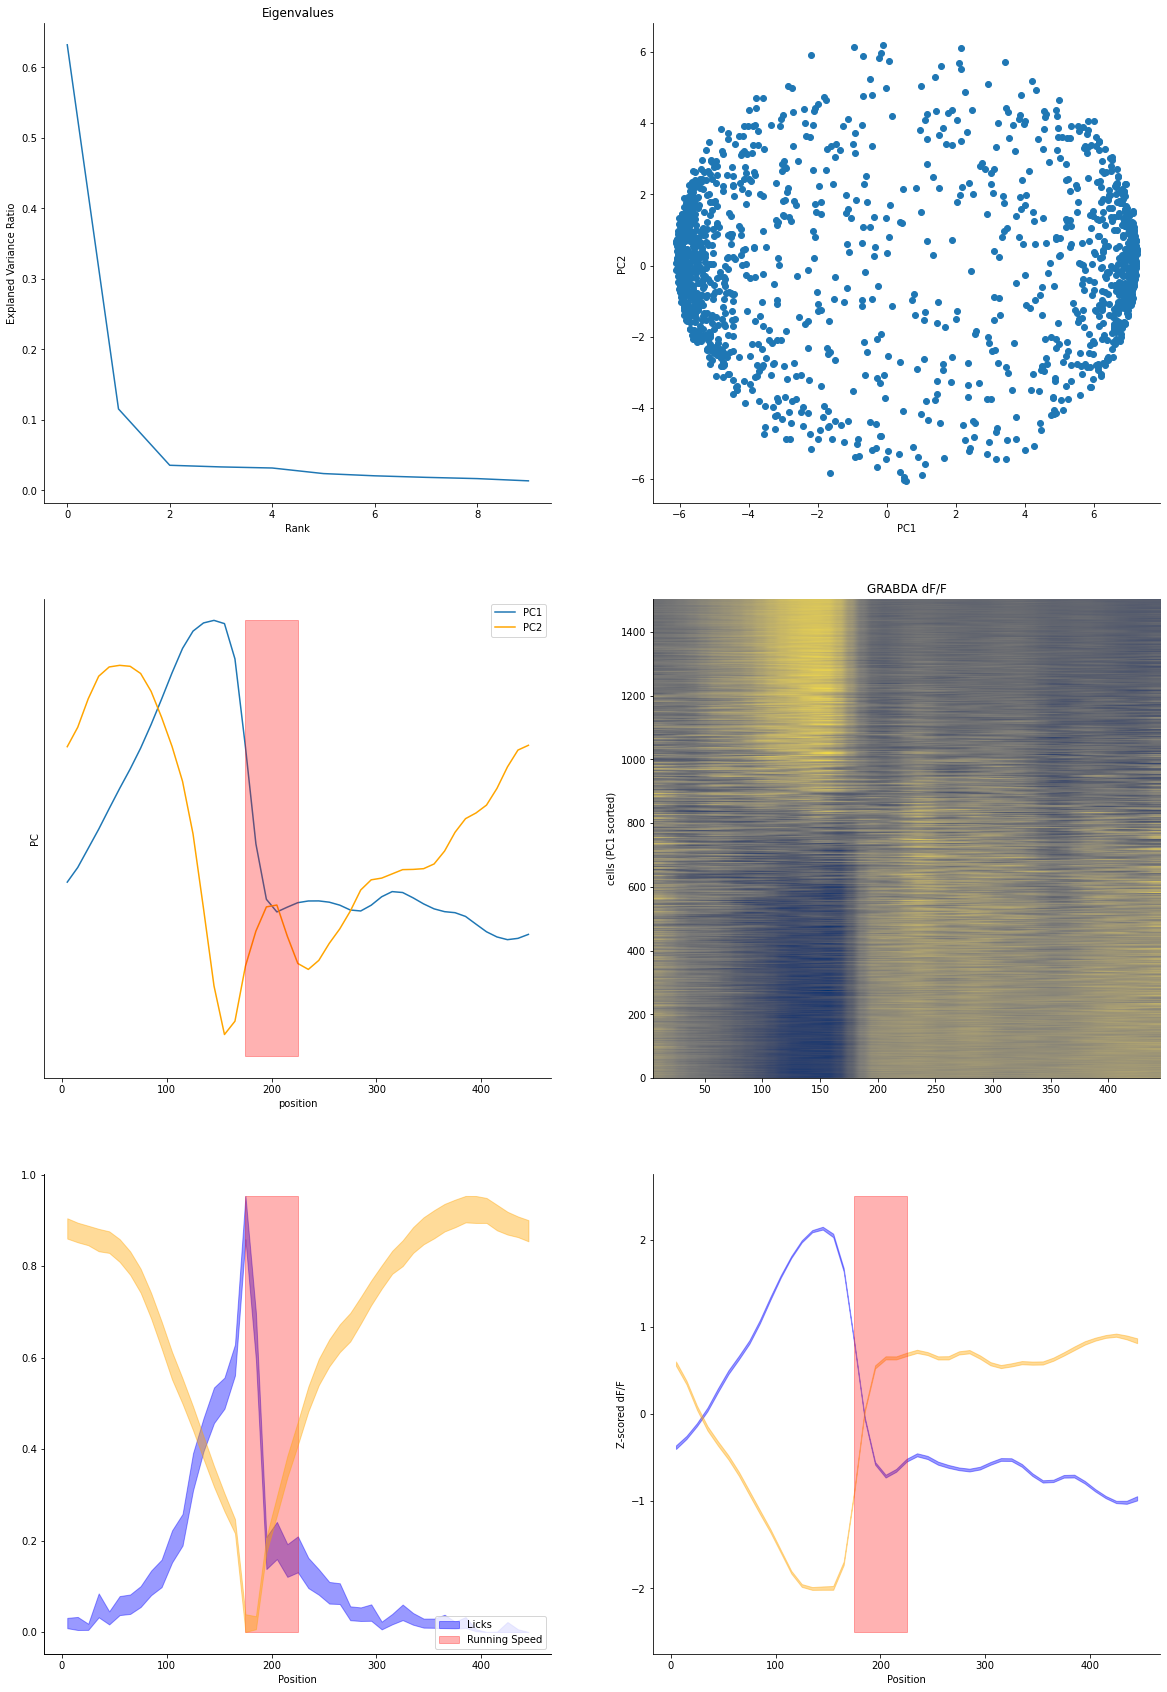

In [44]:
# run pca on average dopamine responses

_dff2_train = np.nanmean(sess.trial_matrices['dff2'][0][::2,:,:],axis=0)
_dff2 = np.nanmean(sess.trial_matrices['dff2'][0][1::2,:,:],axis=0)
_dff2_train[np.isnan(_dff2_train)]=0
_dff2[np.isnan(_dff2)]=0
_dff2_train = sp.ndimage.filters.gaussian_filter1d(_dff2_train,1,axis=0)
_dff2 = sp.ndimage.filters.gaussian_filter1d(_dff2,1,axis=0)
_dff2_train = sp.stats.zscore(_dff2_train,axis=0)
_dff2 = sp.stats.zscore(_dff2,axis=0)


pca = sklearn.decomposition.PCA()
pca.fit(_dff2_train)
_dff2_red = pca.fit_transform(_dff2.T)

# check if direction of projection, RPE signal set to lower projection
rbins = (sess.bin_centers>=rzone[0]-30)*(sess.bin_centers<=rzone[0]+30)

sort_pc0 = np.argsort(proj_pc0)
if _dff2[rbins,:][:,sort_pc0[:10]].mean() < _dff2[rbins,:][:,sort_pc0[-10:]].mean():
    comp_coef=1
    sort_pc0 = sort_pc0[::-1]
    
else:
    comp_coef=-1
_dff2_red *= comp_coef
proj_pc0 = _dff2_red[:,0]
# comp_coef=1

fig,ax = plt.subplots(3,2,figsize=[20,30])
# # skree plot
ax[0,0].plot(pca.explained_variance_ratio_[:10])
ax[0,0].set_xlabel('Rank')
ax[0,0].set_ylabel('Explaned Variance Ratio')
ax[0,0].set_title('Eigenvalues')


ax[0,1].scatter(_dff2_red[:,0],_dff2_red[:,1])
ax[0,1].set_xlabel('PC1')
ax[0,1].set_ylabel('PC2')


_components = comp_coef*pca.components_[:2,:]#-np.amin(pca.components_,axis=1,keepdims=True))/(np.amax(pca.components_,axis=1,keepdims=True)- np.amin(pca.components_,axis=1,keepdims=True))
ax[1,0].plot(sess.bin_centers,_components[0,:])
ax[1,0].plot(sess.bin_centers,_components[1,:],color='orange')
ax[1,0].set_yticks([])
ax[1,0].set_ylabel('PC')
ax[1,0].set_xlabel('position')
ax[1,0].fill_betweenx([min(np.amin(_components),np.amin(-1*_components)),max(np.amax(_components),np.amax(-1*_components))],rzone[0],rzone[1],zorder=10,alpha=.3,color='red')
ax[1,0].legend(['PC1','PC2'])



ax[1,1,].imshow(_dff2[:,sort_pc0].T, aspect='auto',cmap='cividis',vmin=-3,vmax=3,extent=[sess.bin_centers[0],sess.bin_centers[-1],0,_dff2.shape[1]])

ax[1,1].set_ylabel('Position')
ax[1,1].set_ylabel('cells (PC1 scorted)')
ax[1,1].set_title('GRABDA dF/F')



mu,sem = np.nanmean(sess.trial_matrices['licks'][0],axis=0),sp.stats.sem(sess.trial_matrices['licks'][0],axis=0)
ax[2,0].fill_between(sess.bin_centers,mu+sem,mu-sem,alpha=.4,color='blue')
ax[2,0].fill_betweenx([np.amin(mu-sem),np.amax(mu+sem)],rzone[0],rzone[1],zorder=10,alpha=.3,color='red')


mu,sem = np.nanmean(sess.trial_matrices['speed'][0],axis=0),sp.stats.sem(sess.trial_matrices['speed'][0],axis=0)
ax2 = ax[2,0].twinx()
ax2.fill_between(sess.bin_centers,mu+sem,mu-sem,alpha=.4,color='orange')
ax2.set_yticks([])
ax[2,0].legend(['Licks','Running Speed'],loc='lower right')
ax[2,0].set_xlabel('Position')
# ax2.legend(['Running Speed'],location='southwest')

mu,sem = np.nanmean(_dff2[:,sort_pc0[:100]],axis=1),sp.stats.sem(_dff2[:,sort_pc0[:100]],axis=1)
ax[2,1].fill_between(sess.bin_centers,mu+sem,mu-sem,alpha=.4,color='blue')
# ax[2,1].fill_betweenx([np.amin(mu-sem),np.amax(mu+sem)],rzone[0],rzone[1],zorder=10,alpha=.3,color='red')

mu,sem = np.nanmean(_dff2[:,sort_pc0[-100:]],axis=1),sp.stats.sem(_dff2[:,sort_pc0[-100:]],axis=1)
ax[2,1].fill_between(sess.bin_centers,mu+sem,mu-sem,alpha=.4,color='orange')
ax[2,1].fill_betweenx([-2.5,2.5],rzone[0],rzone[1],zorder=10,alpha=.3,color='red')

ax[2,1].set_xlabel('Position')
ax[2,1].set_ylabel('Z-scored dF/F')


for _ax in ax.ravel():
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"%s_%s_eigsort.pdf" % (f['date'],f['scene'])))

In [49]:
# plot ROI masks colored by projection on first pc

roi_im = np.zeros([sess.s2p_ops['Ly'],sess.s2p_ops['Lx']])*np.nan
_stats = sess.s2p_stats[sess.iscell[:,0]>0]
for i, roi in enumerate(_stats):
    
    roi_im[roi['ypix'],roi['xpix']]=-1*_dff2_red[i,0]
    



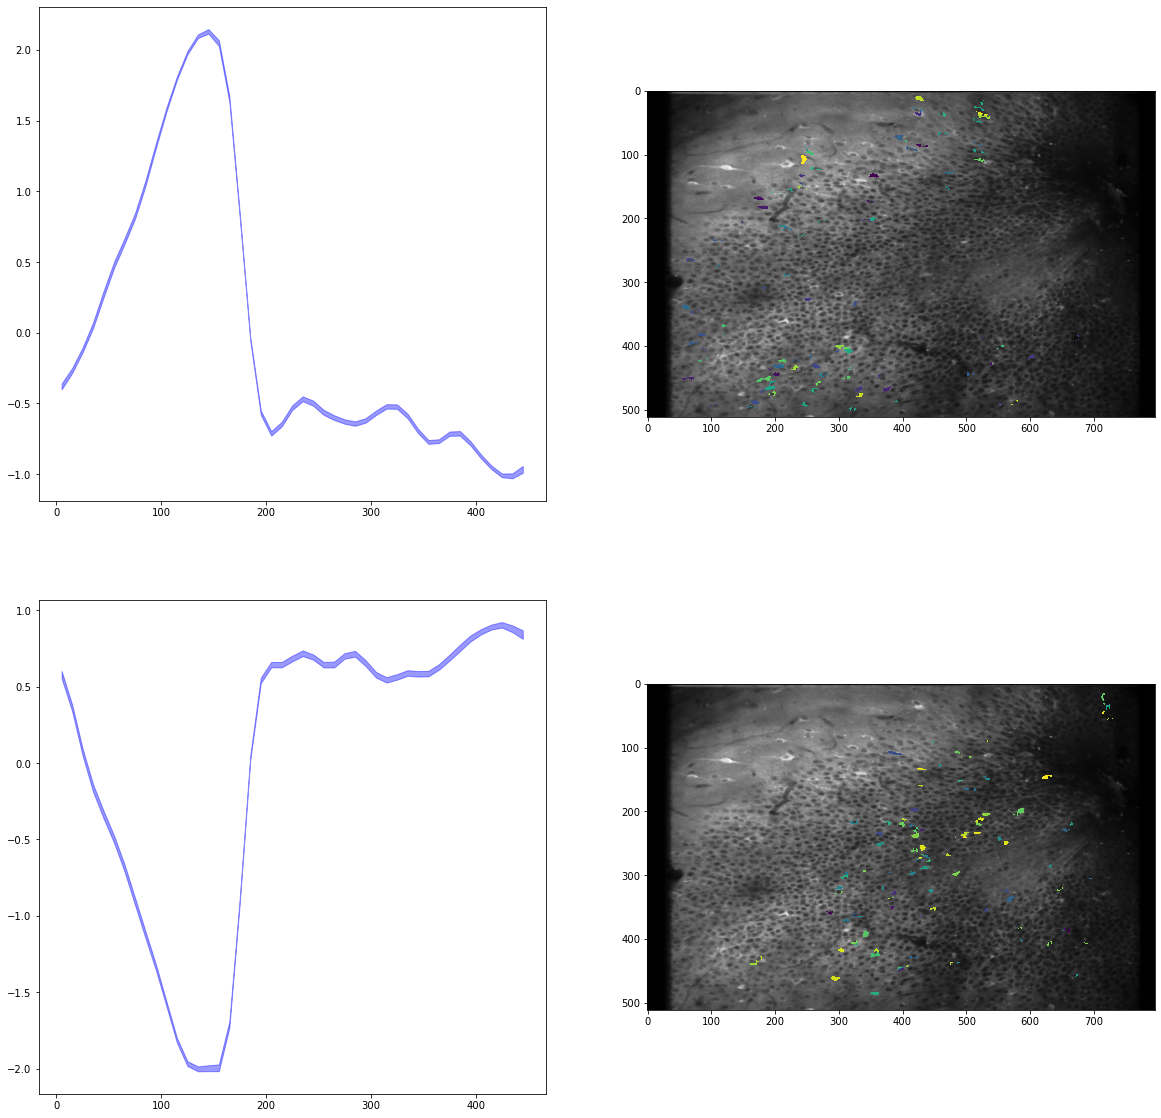

In [50]:
fig,ax = plt.subplots(2,2,figsize=[20,20])


mu,sem = np.nanmean(_dff2[:,sort_pc0[:100]],axis=1),sp.stats.sem(_dff2[:,sort_pc0[:100]],axis=1)
ax[0,0].fill_between(sess.bin_centers,mu+sem,mu-sem,alpha=.4,color='blue')
top_pc_roi_im = np.zeros([sess.s2p_ops['Ly'],sess.s2p_ops['Lx']])*np.nan
for ind in sort_pc0[:100].tolist():
    roi = _stats[ind]
    top_pc_roi_im[roi['ypix'],roi['xpix']]=_dff2_red[ind,0]
ax[0,1].imshow(sess.s2p_ops['meanImg'],cmap="Greys_r")
ax[0,1].imshow(top_pc_roi_im)


mu,sem = np.nanmean(_dff2[:,sort_pc0[-100:]],axis=1),sp.stats.sem(_dff2[:,sort_pc0[-100:]],axis=1)
ax[1,0].fill_between(sess.bin_centers,mu+sem,mu-sem,alpha=.4,color='blue')
top_pc_roi_im = np.zeros([sess.s2p_ops['Ly'],sess.s2p_ops['Lx']])*np.nan
for ind in sort_pc0[-100:].tolist():
    roi = _stats[ind]
    top_pc_roi_im[roi['ypix'],roi['xpix']]=_dff2_red[ind,0]
ax[1,1].imshow(sess.s2p_ops['meanImg'],cmap="Greys_r")
ax[1,1].imshow(top_pc_roi_im)


# mu,sem = np.nanmean(_dff2[:,sort_pc0[-100:]],axis=1),sp.stats.sem(_dff2[:,sort_pc0[-100:]],axis=1)
# ax[2,1].fill_between(sess.bin_centers,mu+sem,mu-sem,alpha=.4,color='orange')
# ax[2,1].fill_betweenx([-2.5,2.5],rzone[0],rzone[1],zorder=10,alpha=.3,color='red')

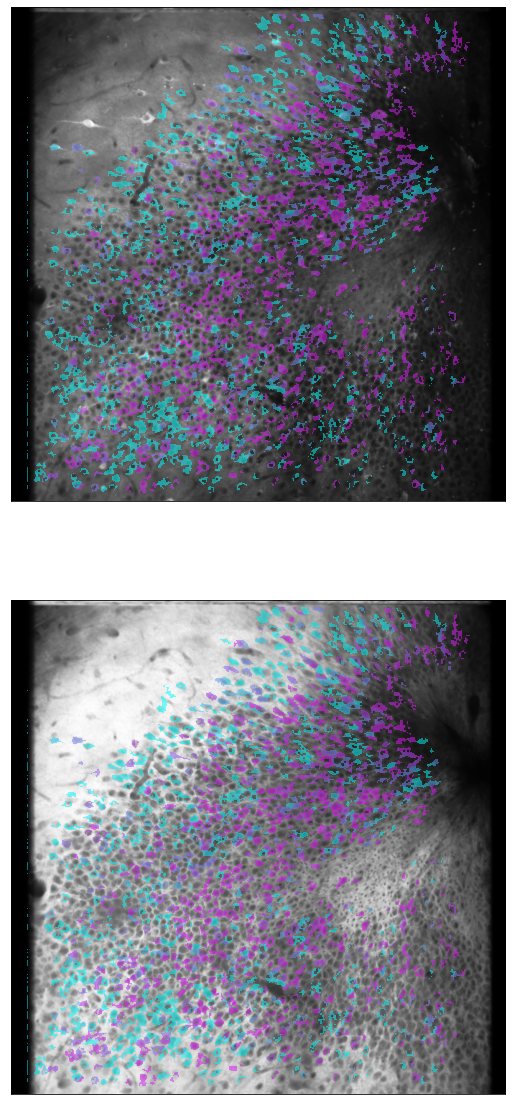

In [51]:
fig,ax = plt.subplots(2,1,figsize=[10,20])
ax[0].imshow(sess.s2p_ops['meanImg'],cmap="Greys_r")
ax[0].imshow(roi_im,cmap='cool',vmin=np.percentile(_dff2_red[:,0],5),vmax=np.percentile(_dff2_red[:,0],95),aspect=796./512,alpha = .5)
ax[0].set_xticks([])
ax[0].set_yticks([])


ax[1].imshow(sess.s2p_ops['meanImg_chan2'],cmap="Greys_r")
ax[1].imshow(roi_im,cmap='cool',vmin=np.percentile(_dff2_red[:,0],5),vmax=np.percentile(_dff2_red[:,0],95),aspect = 796./512., alpha=.5)
ax[1].set_xticks([])
ax[1].set_yticks([])


fig.savefig(os.path.join(figdir,"%s_%s_roiImg.pdf" % (f['date'],f['scene'])))

In [52]:
step_times = [0, *f['zstack_info']['config']['knobby']['schedule'][:,-1].tolist()]

In [53]:
print(step_times)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000]


In [54]:
ref = TwoPUtils.scanner_tools.sbx_utils.sbxread(f['zstack_path'],k=0,N=100).mean(axis=-1)
data = []
for start in step_times[1:]:
    data.append(TwoPUtils.scanner_tools.sbx_utils.sbxread(f['zstack_path'],k=start,N=100).mean(axis=-1))
data = np.array(data)

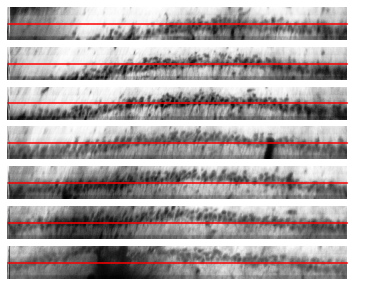

In [55]:
fig,ax = plt.subplots(7,1,figsize=[5*7,5])
for i, slc_ind in enumerate(range(100,796,100)):
    ax[i].imshow(data[::-1,0,slc_ind,:],cmap="Greys_r")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].plot([0,512],[25,25],color='red')
    for side in ['top','right','bottom','left']:
        ax[i].spines[side].set_visible(False)
fig.savefig(os.path.join(figdir,"%s_%s_zstack_side.pdf" % (f['date'],f['scene'])))

In [56]:
import suite2p as s2p
from suite2p.registration import bidiphase, utils, rigid, nonrigid
### ------------- compute registration masks ----------------- ###
refImg = sess.s2p_ops['meanImg']
frames = ref[1,:,:].T
frames = frames[np.newaxis,:,:].astype(np.float32)#*np.ones([10,1,1]).astype(np.float32)


ops = sess.s2p_ops
ops['block_size']=[64,64]

rmin, rmax = np.percentile(refImg,1), np.percentile(refImg,99)
refImg = np.clip(refImg, rmin, rmax)


maskMul, maskOffset = rigid.compute_masks(
    refImg=refImg,
    maskSlope=ops['spatial_taper'] if ops['1Preg'] else 3 * ops['smooth_sigma'],
)
print(maskOffset)
cfRefImg = rigid.phasecorr_reference(
    refImg=refImg,
    smooth_sigma=ops['smooth_sigma'],
    pad_fft=ops['pad_fft'],
)

if ops.get('nonrigid'):
    if 'yblock' not in ops:
        ops['yblock'], ops['xblock'], ops['nblocks'], ops['block_size'], ops[
            'NRsm'] = nonrigid.make_blocks(Ly=ops['Ly'], Lx=ops['Lx'], block_size=ops['block_size'])

    maskMulNR, maskOffsetNR, cfRefImgNR = nonrigid.phasecorr_reference(
        refImg0=refImg,
        maskSlope=ops['spatial_taper'] if ops['1Preg'] else 3 * ops['smooth_sigma'], # slope of taper mask at the edges
        smooth_sigma=ops['smooth_sigma'],
        yblock=ops['yblock'],
        xblock=ops['xblock'],
        pad_fft=ops['pad_fft'],
    )

# ### ------------- register binary to reference image ------------ ###

mean_img = np.zeros((ops['Ly'], ops['Lx']))
rigid_offsets, nonrigid_offsets = [], []



fsmooth = frames.copy().astype(np.float32)
if ops['smooth_sigma_time'] > 0:
    fsmooth = utils.temporal_smooth(data=fsmooth, sigma=ops['smooth_sigma_time'])


# rigid registration
if ops.get('norm_frames', False):
    fsmooth = np.clip(fsmooth, rmin, rmax)
ymax, xmax, cmax = rigid.phasecorr(
    data=rigid.apply_masks(data=fsmooth, maskMul=maskMul, maskOffset=maskOffset),
    cfRefImg=cfRefImg,
    maxregshift=ops['maxregshift'],
    smooth_sigma_time=ops['smooth_sigma_time'],
)
rigid_offsets.append([ymax, xmax, cmax])

for frame, dy, dx in zip(frames, ymax, xmax):
    frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)
    
# for frame, frame_chan2, dy, dx in zip(frames, frames_chan2, ymax, xmax):
#     frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)
#     frame_chan2[:] = rigid.shift_frame(frame=frame_chan2, dy=dy, dx=dx)
    
# non-rigid registration
if ops['nonrigid']:
    # need to also shift smoothed data (if smoothing used)
    if ops['smooth_sigma_time'] or ops['1Preg']:
        for fsm, dy, dx in zip(fsmooth, ymax, xmax):
            fsm[:] = rigid.shift_frame(frame=fsm, dy=dy, dx=dx)
    else:
        fsmooth = frames.copy()

    if ops.get('norm_frames', False):
        fsmooth = np.clip(fsmooth, rmin, rmax)

    ymax1, xmax1, cmax1 = nonrigid.phasecorr(
        data=fsmooth,
        maskMul=maskMulNR.squeeze(),
        maskOffset=maskOffsetNR.squeeze(),
        cfRefImg=cfRefImgNR.squeeze(),
        snr_thresh=ops['snr_thresh'],
        NRsm=ops['NRsm'],
        xblock=ops['xblock'],
        yblock=ops['yblock'],
        maxregshiftNR=10,
    )

    frames = nonrigid.transform_data(
        data=frames,
        nblocks=ops['nblocks'],
        xblock=ops['xblock'],
        yblock=ops['yblock'],
        ymax1=ymax1,
        xmax1=xmax1,
    )
    
    
    nonrigid_offsets.append([ymax1, xmax1, cmax1])



[[5385.952  5363.8467 5336.8374 ... 5336.8374 5363.8467 5385.952 ]
 [5363.8467 5335.447  5300.747  ... 5300.747  5335.447  5363.8467]
 [5336.8374 5300.747  5256.6504 ... 5256.6504 5300.747  5336.8374]
 ...
 [5336.8374 5300.747  5256.6504 ... 5256.6504 5300.747  5336.8374]
 [5363.8467 5335.447  5300.747  ... 5300.747  5335.447  5363.8467]
 [5385.952  5363.8467 5336.8374 ... 5336.8374 5363.8467 5385.952 ]]


In [57]:
data_norm = data/data.mean(axis=-2,keepdims=True).mean(axis=-1,keepdims=True)
data_norm_sm  = sp.ndimage.filters.gaussian_filter(data_norm[:,0,:,:],[3,5,5])

In [58]:
# for slc_ind in range(100,796,20):
#     fig,ax = plt.subplots(1,2,figsize=[15,5])
#     ax[0].imshow(data_norm_sm[::-1,slc_ind,:],cmap="Greys_r")
#     ax[1].plot(data_norm_sm[::-1,slc_ind,200])

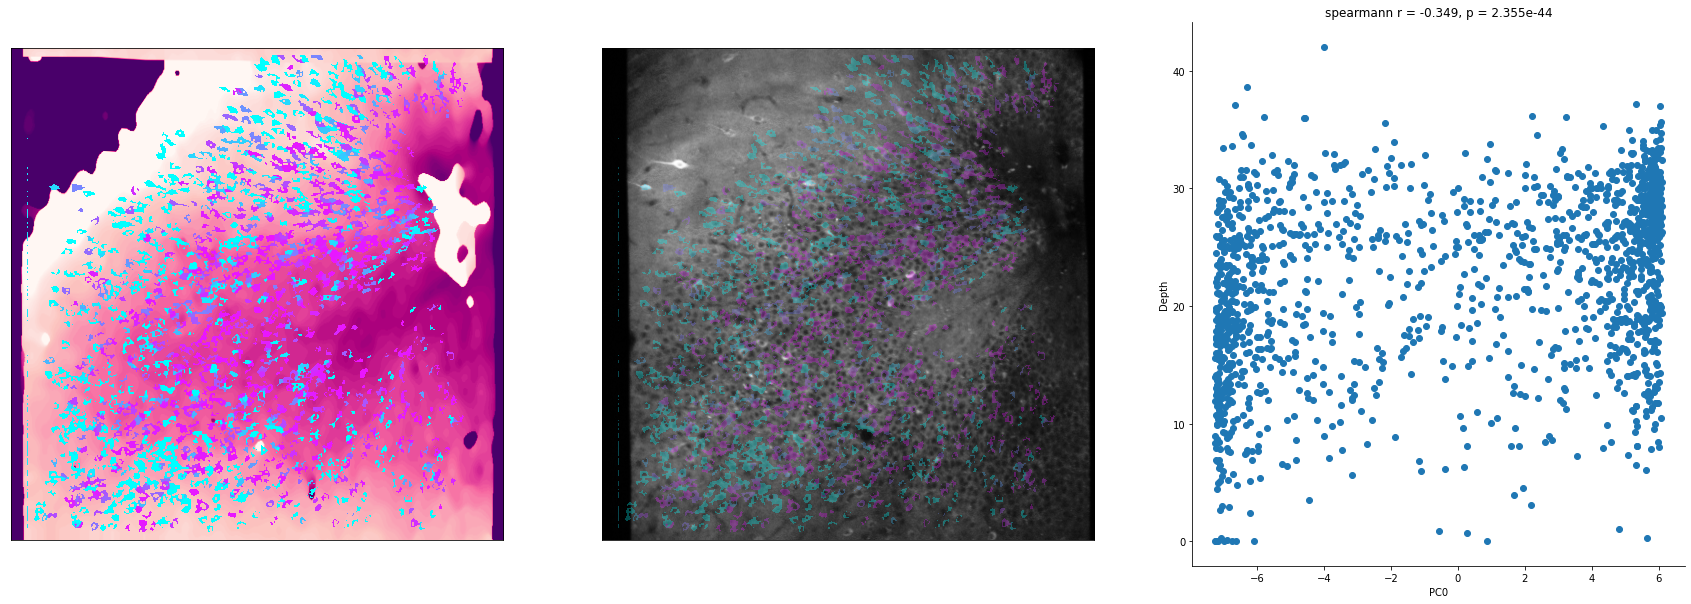

In [59]:
surf = np.argmin(data_norm_sm,axis=0)
surf_sm = sp.ndimage.median_filter(surf,size=[13,13])
surf_sm = surf_sm[np.newaxis,:,:].astype(np.float32)
for frame, dy, dx in zip(surf_sm, ymax, xmax):
    frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)
surf_sm = nonrigid.transform_data(
        data=surf_sm,
        nblocks=ops['nblocks'],
        xblock=ops['xblock'],
        yblock=ops['yblock'],
        ymax1=ymax1,
        xmax1=xmax1,
    )
    
fig, ax = plt.subplots(1,3,figsize=[30,10])
ax[0].imshow(surf_sm.T,cmap='RdPu',aspect=796./512.)
ax[0].imshow(roi_im,cmap='cool',vmin=np.percentile(_dff2_red[:,0],5),vmax=np.percentile(_dff2_red[:,0],95),aspect = 796./512., alpha=1)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(np.squeeze(frames),aspect=796./512,cmap="Greys_r")
ax[1].imshow(roi_im,cmap='cool',vmin=np.percentile(_dff2_red[:,0],5),vmax=np.percentile(_dff2_red[:,0],95),aspect = 796./512., alpha=.3)
ax[1].set_xticks([])
ax[1].set_yticks([])


depth = np.zeros(_stats.shape[0])
for i, roi in enumerate(_stats):
    depth[i]=np.nanmean(surf_sm[0,roi['xpix'],roi['ypix']])
    
ax[2].scatter(proj_pc0,depth)
ax[2].set_xlabel('PC0')
ax[2].set_ylabel('Depth')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

r,p = sp.stats.spearmanr(_dff2_red[:,0],depth)
ax[2].set_title("spearmann r = %.3g, p = %.3e" % (r,p))

fig.savefig(os.path.join(figdir,"%s_%s_depth_plot.pdf" % (f['date'],f['scene'])))


In [80]:
# import tifffile
# tifffile.imwrite("/mnt/BigDisk/2P_scratch/GRABDA7/Zstack/zstack_tiff.tiff",data = np.transpose(data[::-1,1,:,:],axes=(2,0,1)))